# Dimensionality Reduction
This notebook explores the effects of dimensionality reduction on the classification accuracy.

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm, trange

import sklearn
from sklearn import preprocessing
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from py.classifiers import classify, MPP

In [88]:
labelsize = 'large'
dpi = 300

## Extract features

In [5]:
data = pd.read_csv('./data/mbti_1.csv')
docs = list(data['posts'])
personality_types = pd.unique(data['type'])

data = data.replace({ptype: i for i, ptype in enumerate(personality_types)})
y = data['type'].values

## Accuracy vs dimensionality

In [6]:
def reduce_dim(X_tr, X_te, n):
    svd = TruncatedSVD(n_components=n, n_iter=5, random_state=42)
    svd.fit(X_tr)
    return svd.transform(X_tr), svd.transform(X_te)
    
def run(ndims_keep, clf, X_tr, y_tr, X_te, y_te, P=None):
    """Run SVD, then return accuracy score."""
    X_tr_red, X_te_red = reduce_dim(X_tr, X_te, ndims_keep)
    if P is not None: # provide prior probabilities to MPP
        clf.fit(X_tr_red, y_tr, P=P)
    else:
        clf.fit(X_tr_red, y_tr)
    return clf.score(X_te_red, y_te)

### MPP 
Explore how the accuracy changes for the maximum posterior probability classifier for each case (1, 2, 3). The prior probability is taken from the distribution of the training dataset.

In [112]:
vec = TfidfVectorizer(input='content', analyzer='word', ngram_range=(1, 1), use_idf=True)
X = vec.fit_transform(docs)
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=42)
P, _ = np.histogram(y_tr, bins=16, density=True) # prior probability

In [113]:
ndims_keep = [2, 4, 6, 8, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
accuracies_list = []

for case in (1, 2, 3):
    print('case =', case)
    clf = MPP(case)
    accs = [run(n, clf, X_tr, y_tr, X_te, y_te, P) for n in tqdm(ndims_keep)]
    accuracies_list.append(accs)

 50%|█████     | 7/14 [00:18<00:22,  3.25s/it]/Users/austin/Desktop/ML/CS522/projects/final_project/playground/py/classifiers.py:212: RuntimeWarning: invalid value encountered in log
  g[c] = -mdist2 / 2 - np.log(np.linalg.det(self.covs[c])) / 2 + np.log(self.P[c] + 0.000001)
 57%|█████▋    | 8/14 [00:24<00:25,  4.21s/it]/Users/austin/Desktop/ML/CS522/projects/final_project/playground/py/classifiers.py:212: RuntimeWarning: divide by zero encountered in log
  g[c] = -mdist2 / 2 - np.log(np.linalg.det(self.covs[c])) / 2 + np.log(self.P[c] + 0.000001)
100%|██████████| 14/14 [01:30<00:00,  6.46s/it]


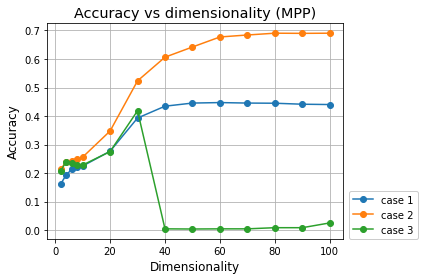

In [114]:
fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True)

for accs in accuracies_list:
    ax.plot(ndims_keep, accs, 'o-')
ax.grid()
ax.legend(['case 1', 'case 2', 'case 3'], framealpha=1, loc=(1.02, 0))
ax.set_xlabel('Dimensionality', fontsize=labelsize)
ax.set_ylabel('Accuracy', fontsize=labelsize)
ax.set_title('Accuracy vs dimensionality (MPP)', fontsize='x-large')
plt.savefig('figures/accuracy_vs_dimensionality_MPP.png', dpi=dpi)

Should redo the above figure with more points.

**Comments**

The MPP classifier does *much* better when the prior probabilities are supplied from the training data. It actually does better than the other classifiers when only a few features are used. Also, case 3 gives a warning sometimes because at least one of the covariance matrices is singular (zero determinant), and we have to take the log of the determinant.

### Feature type comparison

In [ ]:
def extract_ngrams(docs, n):
    """Extrac ngrams from documents. If n=1, words are extracted."""
    analyzer = 'word' if n == 1 else 'char'
    ngram_range = (n, n)
    vec = TfidfVectorizer(input='content', analyzer=analyzer, ngram_range=ngram_range, use_idf=True)
    X = vec.fit_transform(docs)
    return X

#### Dimensionality of each feature type

In [8]:
feature_types = ['word', 'n2', 'n3', 'n4', 'n5']
dimensionalities = []
for n in trange(1, 6):
    X = extract_ngrams(docs, n)
    dimensionalities.append(X.shape[1])

100%|██████████| 5/5 [02:38<00:00, 31.78s/it]


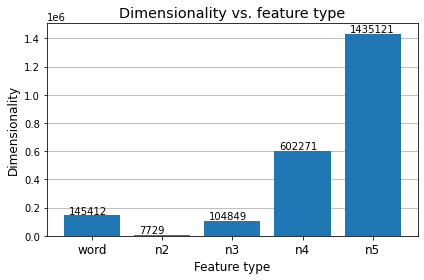

In [111]:
fig, ax = plt.subplots(tight_layout=True)

for i, dimensionality in enumerate(dimensionalities):
    ax.bar(i, dimensionality, zorder=2, color='tab:blue')
    ax.text(i - 0.33, dimensionality + 10000, str(dimensionality))
ax.grid(axis='y')
ax.set_xticklabels([' '] + feature_types, fontsize='large')
ax.set_ylabel('Dimensionality', fontsize=labelsize)
ax.set_xlabel('Feature type', fontsize=labelsize)
ax.set_title('Dimensionality vs. feature type', fontsize='x-large');
fig.set_tight_layout(True)
plt.savefig('figures/dimensionality_vs_featuretype.png', dpi=300)

The dimensionality grows quickly for long n-grams, as longer n-grams are more likely to be unique.

#### Accuracy vs. dimensionality for SVM 
The following feature types are compared: words, 2-grams, 3-grams, 4-grams, 5-grams. A support vector machine with a linear kernel is used.

In [74]:
clf = SVC(kernel='linear')

n_list = list(range(1, 6))
ndims_keep_list = list(range(10, 110, 10))
accuracies = np.zeros((len(n_list), len(ndims_keep_list)))

for i, n in enumerate(n_list):
    print('n =', n)
    for j, ndims_keep in enumerate(ndims_keep_list):
        X = extract_ngrams(docs, n)
        X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=42)
        accuracies[i, j] = run(ndims_keep, clf, X_tr, y_tr, X_te, y_te)
        print('    ndims_keep = {}, acc = {:.4f}'.format(ndims_keep, accuracies[i, j]))

n = 1
    ndims_keep = 10, acc = 0.2513
    ndims_keep = 20, acc = 0.3262
    ndims_keep = 30, acc = 0.4824
    ndims_keep = 40, acc = 0.5533
    ndims_keep = 50, acc = 0.5683
    ndims_keep = 60, acc = 0.5746
    ndims_keep = 70, acc = 0.5844
    ndims_keep = 80, acc = 0.5890
    ndims_keep = 90, acc = 0.5885
    ndims_keep = 100, acc = 0.5937
n = 2
    ndims_keep = 10, acc = 0.2352
    ndims_keep = 20, acc = 0.2519
    ndims_keep = 30, acc = 0.2576
    ndims_keep = 40, acc = 0.2634
    ndims_keep = 50, acc = 0.2726
    ndims_keep = 60, acc = 0.2715
    ndims_keep = 70, acc = 0.2761
    ndims_keep = 80, acc = 0.2813
    ndims_keep = 90, acc = 0.2830
    ndims_keep = 100, acc = 0.2911
n = 3
    ndims_keep = 10, acc = 0.2571
    ndims_keep = 20, acc = 0.2836
    ndims_keep = 30, acc = 0.3141
    ndims_keep = 40, acc = 0.3458
    ndims_keep = 50, acc = 0.3573
    ndims_keep = 60, acc = 0.3971
    ndims_keep = 70, acc = 0.4115
    ndims_keep = 80, acc = 0.4248
    ndims_keep = 90, acc = 0

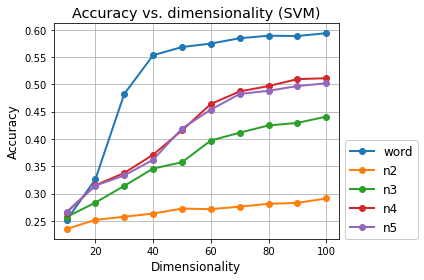

In [95]:
fig, ax = plt.subplots(tight_layout=True)
for acc in accuracies:
    ax.plot(ndims_keep_list, acc, 'o-', lw=2)
ax.grid()
ax.legend(feature_types, framealpha=1, loc=(1.02, 0), fontsize=labelsize)
ax.set_xlabel('Dimensionality', fontsize=labelsize)
ax.set_ylabel('Accuracy', fontsize=labelsize)
ax.set_title('Accuracy vs. dimensionality (SVM)', fontsize='x-large');
plt.savefig('figures/accuracy_vs_dimensionality.png', dpi=dpi)

In [96]:
# X = extract_ngrams(docs, 3)
# X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=42)
# print(run(1000, clf, X_tr, y_tr, X_te, y_te))